In [1]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
# import visdom
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# from livelossplot import PlotLosses

In [2]:
def loadDataset(path_to_dataset, training_size, val_size, test_size, 
                train_bs, val_bs, test_bs, train_shuffle, val_shuffle, test_shuffle,
                image_size, mean, std
                ):
    # data_dir = 'drive/MyDrive' #DOWNLOAD DATA FOR THIS

    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                            transforms.Resize(image_size),transforms.ToTensor(),
                                            transforms.Normalize(mean,std)]
                                         )

    test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                            transforms.Resize(image_size),transforms.ToTensor(),
                                            transforms.Normalize(mean,std)]
                                         )

    # Loading dataset using ImageFolder method. Pass transforms in here.
    train_data = datasets.ImageFolder(path_to_dataset + '/train', transform=train_transforms)
    test_data = datasets.ImageFolder(path_to_dataset + '/test', transform=test_transforms)
    train_ds, val_ds = torch.utils.data.random_split(train_data, (50000, 10000))

    train_indices = np.random.randint(low=0, high=50000, size=training_size, dtype='l')
    val_indices = np.random.randint(low=0, high=10000, size=val_size, dtype='l')
    train_ds =  torch.utils.data.Subset(train_ds, train_indices)\
              if training_size<=50000 else train_ds

    val_ds =  torch.utils.data.Subset(val_ds, val_indices)\
            if val_size<=10000 else val_ds


    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=train_bs, shuffle=train_shuffle)
    val_loader =  torch.utils.data.DataLoader(val_ds, batch_size=val_bs, shuffle=val_shuffle)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_bs, shuffle= test_shuffle)

    return train_loader,val_loader,test_loader


In [3]:
class init_network(nn.Module):
    def __init__(self, no_of_layers, input_dim, neurons_per_layer, dropout):
        super(init_network, self).__init__()
        self.layers = {}
        in_channels = input_dim
        for i in range(no_of_layers+1):
            out_channels = neurons_per_layer[i]
            self.layers['fc_{}'.format(i+1)] = nn.Linear(in_channels, out_channels)
            self.layers['dropout_{}'.format(i+1)] = torch.nn.Dropout(p=dropout, inplace=False)
            self.layers['relu_{}'.format(i+1)] = torch.nn.ReLU()
            in_channels = out_channels
        self.net = nn.ModuleDict(self.layers)
    def forward(self, x):
        layer_names = list(self.layers.keys())
        for layer in layer_names:
            x = self.net[layer](x)
        return F.log_softmax(x,dim=1)

In [4]:

def precision(a, classes=[0]):
    return sum([a[p, p] for p in classes]) / sum(sum(a[:, classes]))


def recall(a, classes=[0]):
    return sum([a[p, p] for p in classes]) / sum(sum(a[classes, :]))


def f1_score(a, classes=[0]):
    return 2 \
        * (
            (
                precision(a, classes)
                * recall(a, classes)
            )
            / (
                precision(a, classes)
                + recall(a, classes)
            )
          )

def accuracy(confusion_matrix):
        """
        Accuracy = correct predictions / total number of observations
        """
        correct = 0
        total_obser = 0

        #  correct predictions lie along the diagonal of the confusion matrix
        for i in range(len(confusion_matrix)):
            correct += confusion_matrix[i][i]
            total_obser += sum(confusion_matrix[i])
        return correct/total_obser

In [5]:
def test(net, test_set_x):
    pred = net(test_set_x)
    return pred

def test_all(net, device, test_loader, loss_fn):
    test_loss = 0
    cm = np.zeros((10,10))
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)

            data = data.view(-1, 28 * 28*1)
            net_out = test(net, data)
            # sum up batch loss
            test_loss += loss_fn(net_out, target).item()
            pred = net_out.data.cpu().max(1)[1]  # get the index of the max log-probability
            
            labels = target.data.cpu()
            for i in range(len(pred)):
                cm[pred[i], labels[i]]+=1
        test_loss /= len(test_loader.dataset)
        return cm, test_loss
    

In [6]:
def save_weights(model, path):
    torch.save(model.state_dict(), path)

In [7]:
def load_weights(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [8]:
def train(net, train_data, val_data,
            learning_rate, training_epochs, loss_func, optimizer, weigts_path):

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    loss_list = []
    # this statement tell our code if there gpu available on our machine or not.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    
    
    for epoch in range(training_epochs):
        for batch_idx, (data, target) in enumerate(train_data):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)        
            data = data.view(-1, 28*28*1)
            optimizer.zero_grad()
            net_out = net(data)
            # print('Targets',target)
            # print("Prediction",net_out)
            loss = loss_func(net_out, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_data.dataset),
                               100. * batch_idx / len(train_data), loss.item()))
        save_weights(net, weigts_path)
        cm, loss = test_all(net, device, val_data, loss_func)
        acc = accuracy(cm)
        prec = {str(i): precision(cm, classes = [i]) for i in range(10)}
        rec = {str(i): recall(cm, classes = [i]) for i in range(10)}
        f1_scr = {str(i): f1_score(cm, classes = [i]) for i in range(10)}
        print('Epoch{} accuracy on test data: {}'.format(epoch, acc))
        print('Epoch{} precision on test data: {}'.format(epoch, prec))
        print('Epoch{} recall on test data: {}'.format(epoch, rec))
        print('Epoch{} f1_score on test data: {}'.format(epoch, f1_scr))
        print('Epoch{} loss on test data: {}'.format(epoch, loss))
        accuracy_list.append(acc)
        precision_list.append(prec)
        recall_list.append(rec)
        f1_score_list.append(f1_scr)
        loss_list.append(loss)

        
    return net, accuracy_list, precision_list, recall_list, f1_score_list, loss_list

In [10]:

dataset_path='MNIST_Data/'
train_loader,val_loader,test_loader = loadDataset(dataset_path, training_size=50000, val_size=10000, test_size=10000, 
                            train_bs = 64, val_bs = 64, test_bs = 64, train_shuffle=True , val_shuffle=False, test_shuffle=False,
                            image_size = (28,28), mean = [0],std =[0.5]
                            )


net = init_network(4, 784, [256, 128, 64, 32, 10],0.1)
weights_path = 'mnist_weights/weights.pth'
learning_rate=0.001
training_epochs=20
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()


net, accuracy_list, precision_list, recall_list, f1_score_list, loss_list = train(net, train_loader, test_loader,
learning_rate, training_epochs, criterion, optimizer, weights_path)



Train Epoch: 0 [0/50000 (0%)]	Loss: 2.294062
Train Epoch: 0 [640/50000 (1%)]	Loss: 2.313564
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.306887
Train Epoch: 0 [1920/50000 (4%)]	Loss: 2.305472
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.293846
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.301694
Train Epoch: 0 [3840/50000 (8%)]	Loss: 2.295991
Train Epoch: 0 [4480/50000 (9%)]	Loss: 2.294732
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.308291
Train Epoch: 0 [5760/50000 (12%)]	Loss: 2.292695
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.293150
Train Epoch: 0 [7040/50000 (14%)]	Loss: 2.303573
Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.308261
Train Epoch: 0 [8320/50000 (17%)]	Loss: 2.290915
Train Epoch: 0 [8960/50000 (18%)]	Loss: 2.298274
Train Epoch: 0 [9600/50000 (19%)]	Loss: 2.299939
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.304225
Train Epoch: 0 [10880/50000 (22%)]	Loss: 2.299971
Train Epoch: 0 [11520/50000 (23%)]	Loss: 2.293916
Train Epoch: 0 [12160/50000 (24%)]	Loss: 2.304828
Train Epoch: 0 [12800/50000 

/home/ahmadr/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Epoch0 accuracy on test data: 0.317
Epoch0 precision on test data: {'0': 0.9040816326530612, '1': 0.8581497797356828, '2': 0.040697674418604654, '3': 0.0, '4': 0.670061099796334, '5': 0.04596412556053812, '6': 0.4196242171189979, '7': 0.0, '8': 0.17145790554414783, '9': 0.0}
Epoch0 recall on test data: {'0': 0.20466620466620467, '1': 0.5426183844011142, '2': 0.3559322033898305, '3': nan, '4': 0.34306569343065696, '5': 0.22043010752688172, '6': 0.3347210657785179, '7': nan, '8': 0.3686534216335541, '9': nan}
Epoch0 f1_score on test data: {'0': 0.333772838576003, '1': 0.6648464163822526, '2': 0.07304347826086957, '3': nan, '4': 0.4537931034482759, '5': 0.07606679035250465, '6': 0.37239462714219546, '7': nan, '8': 0.23405746320953047, '9': nan}
Epoch0 loss on test data: 0.03485116232633591
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.224052
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.204700
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.201036
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.209027
Train Epoch: 1

Train Epoch: 2 [34560/50000 (69%)]	Loss: 1.506664
Train Epoch: 2 [35200/50000 (70%)]	Loss: 1.565755
Train Epoch: 2 [35840/50000 (72%)]	Loss: 1.529893
Train Epoch: 2 [36480/50000 (73%)]	Loss: 1.397773
Train Epoch: 2 [37120/50000 (74%)]	Loss: 1.565917
Train Epoch: 2 [37760/50000 (75%)]	Loss: 1.458019
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.306343
Train Epoch: 2 [39040/50000 (78%)]	Loss: 1.457712
Train Epoch: 2 [39680/50000 (79%)]	Loss: 1.356324
Train Epoch: 2 [40320/50000 (81%)]	Loss: 1.426179
Train Epoch: 2 [40960/50000 (82%)]	Loss: 1.333722
Train Epoch: 2 [41600/50000 (83%)]	Loss: 1.166274
Train Epoch: 2 [42240/50000 (84%)]	Loss: 1.488021
Train Epoch: 2 [42880/50000 (86%)]	Loss: 1.294047
Train Epoch: 2 [43520/50000 (87%)]	Loss: 1.032244
Train Epoch: 2 [44160/50000 (88%)]	Loss: 1.241845
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.268705
Train Epoch: 2 [45440/50000 (91%)]	Loss: 1.414621
Train Epoch: 2 [46080/50000 (92%)]	Loss: 1.128097
Train Epoch: 2 [46720/50000 (93%)]	Loss: 1.137521


Train Epoch: 4 [17920/50000 (36%)]	Loss: 1.137638
Train Epoch: 4 [18560/50000 (37%)]	Loss: 1.266720
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.009765
Train Epoch: 4 [19840/50000 (40%)]	Loss: 1.266444
Train Epoch: 4 [20480/50000 (41%)]	Loss: 1.132972
Train Epoch: 4 [21120/50000 (42%)]	Loss: 1.175076
Train Epoch: 4 [21760/50000 (43%)]	Loss: 1.180852
Train Epoch: 4 [22400/50000 (45%)]	Loss: 1.077203
Train Epoch: 4 [23040/50000 (46%)]	Loss: 1.010897
Train Epoch: 4 [23680/50000 (47%)]	Loss: 0.910322
Train Epoch: 4 [24320/50000 (49%)]	Loss: 1.083527
Train Epoch: 4 [24960/50000 (50%)]	Loss: 1.250242
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.104650
Train Epoch: 4 [26240/50000 (52%)]	Loss: 1.211271
Train Epoch: 4 [26880/50000 (54%)]	Loss: 1.140113
Train Epoch: 4 [27520/50000 (55%)]	Loss: 1.281534
Train Epoch: 4 [28160/50000 (56%)]	Loss: 1.115029
Train Epoch: 4 [28800/50000 (58%)]	Loss: 0.975402
Train Epoch: 4 [29440/50000 (59%)]	Loss: 0.871500
Train Epoch: 4 [30080/50000 (60%)]	Loss: 1.124958


/home/ahmadr/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Epoch4 accuracy on test data: 0.6482
Epoch4 precision on test data: {'0': 0.8755102040816326, '1': 0.8801762114537445, '2': 0.7703488372093024, '3': 0.7594059405940594, '4': 0.8462321792260692, '5': 0.7533632286995515, '6': 0.8444676409185804, '7': 0.0, '8': 0.771047227926078, '9': 0.0}
Epoch4 recall on test data: {'0': 0.6766561514195584, '1': 0.7661042944785276, '2': 0.7492931196983977, '3': 0.7121634168987929, '4': 0.5067073170731707, '5': 0.5177195685670262, '6': 0.7970443349753694, '7': 0.0, '8': 0.5625468164794007, '9': nan}
Epoch4 f1_score on test data: {'0': 0.7633451957295374, '1': 0.8191881918819188, '2': 0.7596751075011945, '3': 0.735026353617633, '4': 0.6338672768878718, '5': 0.6136986301369862, '6': 0.8200709579320831, '7': nan, '8': 0.6504980511043742, '9': nan}
Epoch4 loss on test data: 0.016362658533453943
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.307665
Train Epoch: 5 [640/50000 (1%)]	Loss: 1.006060
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.816678
Train Epoch: 5 [1920/50000

Train Epoch: 6 [34560/50000 (69%)]	Loss: 0.792726
Train Epoch: 6 [35200/50000 (70%)]	Loss: 0.935419
Train Epoch: 6 [35840/50000 (72%)]	Loss: 1.129249
Train Epoch: 6 [36480/50000 (73%)]	Loss: 0.925140
Train Epoch: 6 [37120/50000 (74%)]	Loss: 0.901193
Train Epoch: 6 [37760/50000 (75%)]	Loss: 1.018851
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.995162
Train Epoch: 6 [39040/50000 (78%)]	Loss: 0.880204
Train Epoch: 6 [39680/50000 (79%)]	Loss: 1.010580
Train Epoch: 6 [40320/50000 (81%)]	Loss: 1.001166
Train Epoch: 6 [40960/50000 (82%)]	Loss: 0.914361
Train Epoch: 6 [41600/50000 (83%)]	Loss: 0.887083
Train Epoch: 6 [42240/50000 (84%)]	Loss: 0.872707
Train Epoch: 6 [42880/50000 (86%)]	Loss: 0.904570
Train Epoch: 6 [43520/50000 (87%)]	Loss: 0.977283
Train Epoch: 6 [44160/50000 (88%)]	Loss: 0.974023
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.160938
Train Epoch: 6 [45440/50000 (91%)]	Loss: 0.827800
Train Epoch: 6 [46080/50000 (92%)]	Loss: 0.939982
Train Epoch: 6 [46720/50000 (93%)]	Loss: 1.070017


Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.814011
Train Epoch: 8 [18560/50000 (37%)]	Loss: 1.030956
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.825222
Train Epoch: 8 [19840/50000 (40%)]	Loss: 0.727733
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.813686
Train Epoch: 8 [21120/50000 (42%)]	Loss: 0.946501
Train Epoch: 8 [21760/50000 (43%)]	Loss: 1.177437
Train Epoch: 8 [22400/50000 (45%)]	Loss: 0.908705
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.716188
Train Epoch: 8 [23680/50000 (47%)]	Loss: 0.867288
Train Epoch: 8 [24320/50000 (49%)]	Loss: 1.113055
Train Epoch: 8 [24960/50000 (50%)]	Loss: 0.965218
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.012705
Train Epoch: 8 [26240/50000 (52%)]	Loss: 0.941593
Train Epoch: 8 [26880/50000 (54%)]	Loss: 0.880926
Train Epoch: 8 [27520/50000 (55%)]	Loss: 0.869874
Train Epoch: 8 [28160/50000 (56%)]	Loss: 0.851062
Train Epoch: 8 [28800/50000 (58%)]	Loss: 0.974450
Train Epoch: 8 [29440/50000 (59%)]	Loss: 0.767401
Train Epoch: 8 [30080/50000 (60%)]	Loss: 0.928684


Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.944208
Train Epoch: 10 [1920/50000 (4%)]	Loss: 0.909283
Train Epoch: 10 [2560/50000 (5%)]	Loss: 0.879825
Train Epoch: 10 [3200/50000 (6%)]	Loss: 0.779347
Train Epoch: 10 [3840/50000 (8%)]	Loss: 0.739259
Train Epoch: 10 [4480/50000 (9%)]	Loss: 0.919896
Train Epoch: 10 [5120/50000 (10%)]	Loss: 0.840510
Train Epoch: 10 [5760/50000 (12%)]	Loss: 0.934901
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.704991
Train Epoch: 10 [7040/50000 (14%)]	Loss: 0.676573
Train Epoch: 10 [7680/50000 (15%)]	Loss: 0.886417
Train Epoch: 10 [8320/50000 (17%)]	Loss: 0.889069
Train Epoch: 10 [8960/50000 (18%)]	Loss: 0.757620
Train Epoch: 10 [9600/50000 (19%)]	Loss: 0.898115
Train Epoch: 10 [10240/50000 (20%)]	Loss: 0.657119
Train Epoch: 10 [10880/50000 (22%)]	Loss: 0.788184
Train Epoch: 10 [11520/50000 (23%)]	Loss: 0.774948
Train Epoch: 10 [12160/50000 (24%)]	Loss: 0.926852
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.654664
Train Epoch: 10 [13440/50000 (27%)]	Loss: 0.624286


Train Epoch: 11 [44800/50000 (90%)]	Loss: 0.831073
Train Epoch: 11 [45440/50000 (91%)]	Loss: 0.844030
Train Epoch: 11 [46080/50000 (92%)]	Loss: 0.932406
Train Epoch: 11 [46720/50000 (93%)]	Loss: 0.806716
Train Epoch: 11 [47360/50000 (95%)]	Loss: 0.943961
Train Epoch: 11 [48000/50000 (96%)]	Loss: 0.857975
Train Epoch: 11 [48640/50000 (97%)]	Loss: 1.052432
Train Epoch: 11 [49280/50000 (98%)]	Loss: 0.705002
Train Epoch: 11 [49920/50000 (100%)]	Loss: 0.720683
Epoch11 accuracy on test data: 0.6947
Epoch11 precision on test data: {'0': 0.9438775510204082, '1': 0.8731277533039647, '2': 0.8575581395348837, '3': 0.8643564356435643, '4': 0.8869653767820774, '5': 0.8374439461883408, '6': 0.8674321503131524, '7': 0.0, '8': 0.8459958932238193, '9': 0.0}
Epoch11 recall on test data: {'0': 0.3474830954169797, '1': 0.9201485608170845, '2': 0.8294283036551078, '3': 0.7611159546643418, '4': 0.7294807370184254, '5': 0.8393258426966292, '6': 0.8925886143931256, '7': 0.0, '8': 0.8015564202334631, '9': 0.0}

Train Epoch: 13 [26880/50000 (54%)]	Loss: 0.909977
Train Epoch: 13 [27520/50000 (55%)]	Loss: 0.391545
Train Epoch: 13 [28160/50000 (56%)]	Loss: 0.920739
Train Epoch: 13 [28800/50000 (58%)]	Loss: 0.447596
Train Epoch: 13 [29440/50000 (59%)]	Loss: 0.708042
Train Epoch: 13 [30080/50000 (60%)]	Loss: 0.948311
Train Epoch: 13 [30720/50000 (61%)]	Loss: 0.681562
Train Epoch: 13 [31360/50000 (63%)]	Loss: 0.934449
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.701252
Train Epoch: 13 [32640/50000 (65%)]	Loss: 0.836748
Train Epoch: 13 [33280/50000 (66%)]	Loss: 0.920860
Train Epoch: 13 [33920/50000 (68%)]	Loss: 0.863021
Train Epoch: 13 [34560/50000 (69%)]	Loss: 0.745940
Train Epoch: 13 [35200/50000 (70%)]	Loss: 0.879105
Train Epoch: 13 [35840/50000 (72%)]	Loss: 0.813077
Train Epoch: 13 [36480/50000 (73%)]	Loss: 0.775207
Train Epoch: 13 [37120/50000 (74%)]	Loss: 0.885434
Train Epoch: 13 [37760/50000 (75%)]	Loss: 0.793284
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.768857
Train Epoch: 13 [39040/50000 (7

Train Epoch: 15 [8960/50000 (18%)]	Loss: 0.566608
Train Epoch: 15 [9600/50000 (19%)]	Loss: 0.705330
Train Epoch: 15 [10240/50000 (20%)]	Loss: 0.910191
Train Epoch: 15 [10880/50000 (22%)]	Loss: 0.647752
Train Epoch: 15 [11520/50000 (23%)]	Loss: 0.785685
Train Epoch: 15 [12160/50000 (24%)]	Loss: 0.784101
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.780605
Train Epoch: 15 [13440/50000 (27%)]	Loss: 0.798827
Train Epoch: 15 [14080/50000 (28%)]	Loss: 0.857392
Train Epoch: 15 [14720/50000 (29%)]	Loss: 0.792688
Train Epoch: 15 [15360/50000 (31%)]	Loss: 0.810180
Train Epoch: 15 [16000/50000 (32%)]	Loss: 0.438107
Train Epoch: 15 [16640/50000 (33%)]	Loss: 0.620595
Train Epoch: 15 [17280/50000 (35%)]	Loss: 0.685700
Train Epoch: 15 [17920/50000 (36%)]	Loss: 0.689069
Train Epoch: 15 [18560/50000 (37%)]	Loss: 0.832817
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.867997
Train Epoch: 15 [19840/50000 (40%)]	Loss: 0.778650
Train Epoch: 15 [20480/50000 (41%)]	Loss: 0.619607
Train Epoch: 15 [21120/50000 (42%

Train Epoch: 17 [1280/50000 (3%)]	Loss: 0.846449
Train Epoch: 17 [1920/50000 (4%)]	Loss: 0.678538
Train Epoch: 17 [2560/50000 (5%)]	Loss: 0.636158
Train Epoch: 17 [3200/50000 (6%)]	Loss: 1.003740
Train Epoch: 17 [3840/50000 (8%)]	Loss: 0.800037
Train Epoch: 17 [4480/50000 (9%)]	Loss: 0.577560
Train Epoch: 17 [5120/50000 (10%)]	Loss: 0.694882
Train Epoch: 17 [5760/50000 (12%)]	Loss: 0.631037
Train Epoch: 17 [6400/50000 (13%)]	Loss: 1.059035
Train Epoch: 17 [7040/50000 (14%)]	Loss: 0.770112
Train Epoch: 17 [7680/50000 (15%)]	Loss: 0.731540
Train Epoch: 17 [8320/50000 (17%)]	Loss: 0.630414
Train Epoch: 17 [8960/50000 (18%)]	Loss: 0.877974
Train Epoch: 17 [9600/50000 (19%)]	Loss: 0.714315
Train Epoch: 17 [10240/50000 (20%)]	Loss: 0.889876
Train Epoch: 17 [10880/50000 (22%)]	Loss: 0.728219
Train Epoch: 17 [11520/50000 (23%)]	Loss: 1.005145
Train Epoch: 17 [12160/50000 (24%)]	Loss: 0.788840
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.707207
Train Epoch: 17 [13440/50000 (27%)]	Loss: 0.651391


Train Epoch: 18 [44800/50000 (90%)]	Loss: 0.557821
Train Epoch: 18 [45440/50000 (91%)]	Loss: 0.532805
Train Epoch: 18 [46080/50000 (92%)]	Loss: 0.811051
Train Epoch: 18 [46720/50000 (93%)]	Loss: 0.803697
Train Epoch: 18 [47360/50000 (95%)]	Loss: 0.683935
Train Epoch: 18 [48000/50000 (96%)]	Loss: 0.662482
Train Epoch: 18 [48640/50000 (97%)]	Loss: 0.492599
Train Epoch: 18 [49280/50000 (98%)]	Loss: 0.778963
Train Epoch: 18 [49920/50000 (100%)]	Loss: 0.649476
Epoch18 accuracy on test data: 0.7027
Epoch18 precision on test data: {'0': 0.9540816326530612, '1': 0.8898678414096917, '2': 0.8662790697674418, '3': 0.8673267326732673, '4': 0.8788187372708758, '5': 0.8419282511210763, '6': 0.8830897703549061, '7': 0.0, '8': 0.8747433264887063, '9': 0.0}
Epoch18 recall on test data: {'0': 0.30337443218689164, '1': 0.9483568075117371, '2': 0.8904382470119522, '3': 0.8225352112676056, '4': 0.8419512195121951, '5': 0.8919239904988123, '6': 0.9266155531215772, '7': 0.0, '8': 0.852, '9': 0.0}
Epoch18 f1_

Text(0, 0.5, 'Accuracy')

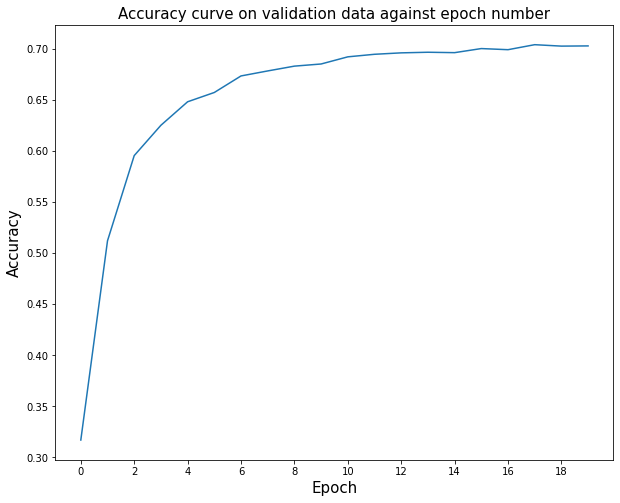

In [52]:
plt.figure(figsize=(10,8))
plt.plot(range(training_epochs), accuracy_list)
plt.xticks(range(0,training_epochs,2))
plt.title('Accuracy curve on validation data against epoch number',fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy',fontsize=15)

Text(0, 0.5, 'Validation Loss')

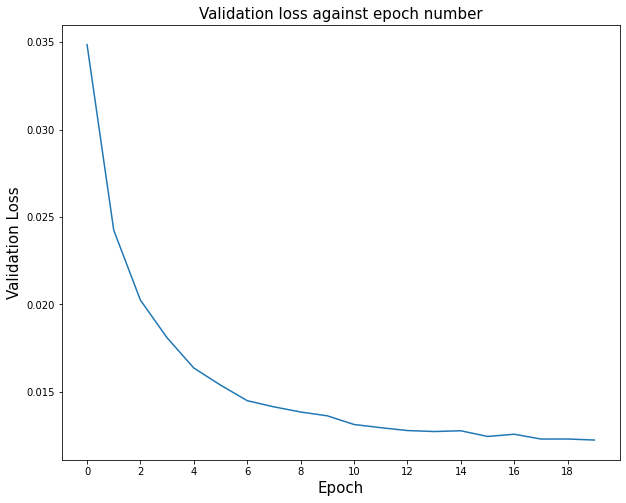

In [53]:
plt.figure(figsize=(10,8))
plt.plot(range(training_epochs), loss_list)
plt.xticks(range(0,training_epochs,2))
plt.title('Validation loss against epoch number',fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Validation Loss',fontsize=15)

Text(0, 0.5, 'Precision')

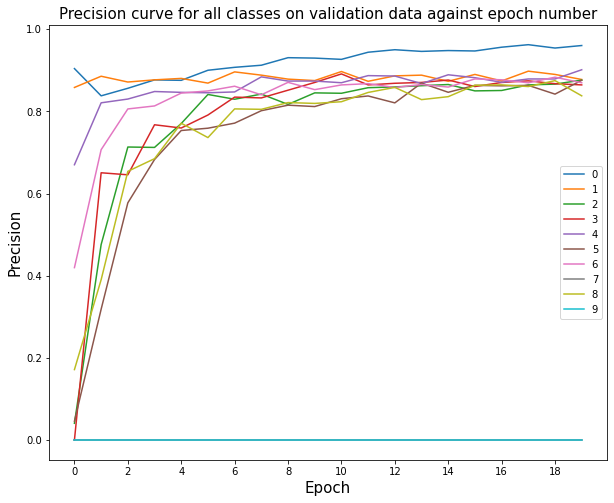

In [46]:
precisions = {str(j): [precision_list[i][str(j)] for i in range(len(precision_list))] for j in range(10)}
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(range(training_epochs), precisions[str(i)], label=str(i))
plt.legend()
plt.xticks(range(0,training_epochs,2))
plt.title('Precision curve for all classes on validation data against epoch number',fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Precision',fontsize=15)

Text(0, 0.5, 'Recall')

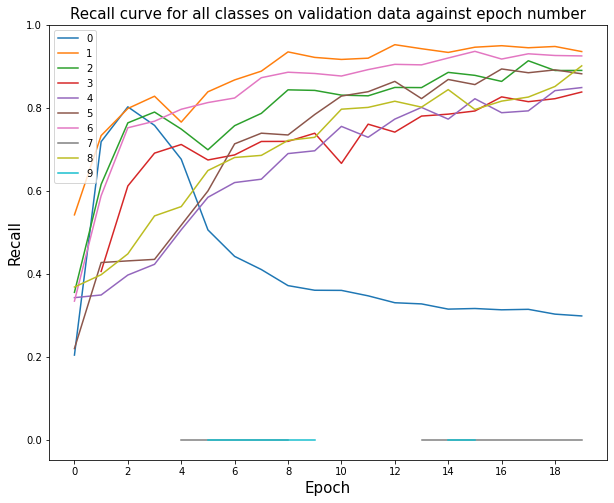

In [47]:
recalls = {str(j): [recall_list[i][str(j)] for i in range(len(recall_list))] for j in range(10)}
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(range(training_epochs), recalls[str(i)], label=str(i))
plt.legend()
plt.xticks(range(0,training_epochs,2))
plt.title('Recall curve for all classes on validation data against epoch number',fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Recall',fontsize=15)

Text(0, 0.5, 'F1 Score')

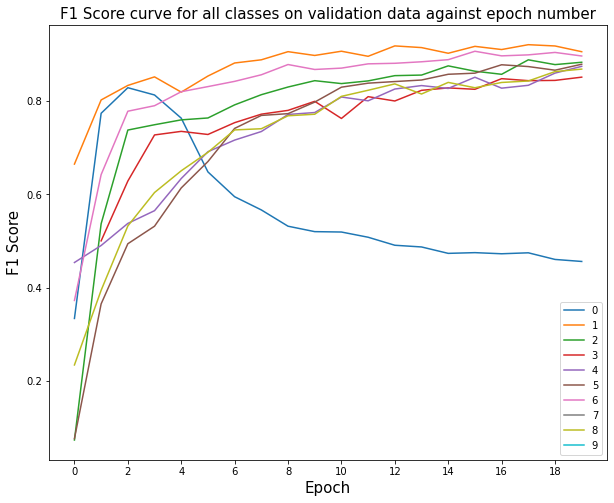

In [48]:
f1_scores = {str(j): [f1_score_list[i][str(j)] for i in range(len(f1_score_list))] for j in range(10)}
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(range(training_epochs), f1_scores[str(i)], label=str(i))
plt.legend()
plt.xticks(range(0,training_epochs,2))
plt.title('F1 Score curve for all classes on validation data against epoch number',fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('F1 Score',fontsize=15)